## Direct Optimization + A* sampling for TSP 

In [1]:
import os
import numpy as np
import torch
import kruskals_cpp 
import matplotlib
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [2]:
from utils import load_model
from dirpg_tsp import dirpg as dirpg_m
from dirpg_tsp import mst
from dirpg_tsp.a_star_sampling import Node, Trajectory



In [3]:

class opts:
    def __init__(self,
                 max_interactions=200,
                 alpha=1.0,
                 epsilon=2.0,
                 heuristic='mst',
                 independent_gumbel=False,
                 first_improvement=False,
                 dynamic_weighting = False,
                 dfs_like=False,
                 not_prune=False):        
        self.max_interactions = max_interactions
        self.first_improvement = first_improvement
        self.dynamic_weighting = dynamic_weighting
        self.independent_gumbel = independent_gumbel
        self.heuristic = heuristic
        self.dfs_like = dfs_like
        self.not_prune = not_prune
        self.alpha=alpha
        self.epsilon = epsilon

dirpg_opts = opts()
num_cities = 8
model, _ = load_model('outputs/tsp_{}/jupyter_example/DirPG_20200506T134440/'.format(num_cities), epoch = 0) # 'pretrained/tsp_100/')
#model, _ = load_model('outputs/tsp_{}/visuals/DirPG_20200421T162602/'.format(num_cities), epoch = 1)
#model, _ = load_model('outputs/tsp_{}/2epochs_ours/DirPG_20200506T004445/'.format(num_cities), epoch = 0)
model.eval()  # Put in evaluation mode to not track gradients
dirpg = dirpg_m.DirPG(model, dirpg_opts)


  [*] Loading model from outputs/tsp_8/jupyter_example/DirPG_20200506T134440/epoch-0.pt


In [4]:
import heapq
from utils import utils_gumbel
import networkx as nx
import time

class PriorityQueue:
    def __init__(self,
                 init_state,
                 distance_mat,
                 epsilon,
                 search_params,
                 inference=False
                 ):
        self.queue = []
        self.G = nx.Graph()
        
        Node.epsilon = epsilon
        init_state = init_state._replace(first_a=init_state.first_a.squeeze(0),
                                         prev_a=init_state.prev_a.squeeze(0),
                                         visited_=init_state.visited_.squeeze(0),
                                         lengths=init_state.lengths.squeeze(0),
                                         cur_coord=init_state.cur_coord.squeeze(0),
                                         ids=init_state.ids.squeeze(0),
                                         i=init_state.i.squeeze(0))

        special_action = init_state.prev_a.item()
        not_visited = [i for i in range(init_state.loc.size(1)) if i != special_action]
        self.first_coord = init_state.loc[init_state.ids, special_action]
        self.graph_size = distance_mat.shape[1]

        #           global nodes parameters      #
        Node.alpha = search_params['alpha']
        Node.epsilon = epsilon
        Node.dynamic_weighting = search_params['dynamic_weighting']
        Node.heuristic = search_params['heuristic']
        Node.graph_size = self.graph_size
        Node.dist = distance_mat
        
        self.mst_edges = mst.prim_pytorch(distance_mat)
        self.mst_val = self.mst_edges.sum()
        
        self.root_node = Node(id=init_state.ids,
                         first_a=init_state.first_a.item(),
                         next_actions=not_visited, # torch.tensor(not_visited),  # number of cities
                         not_visited=not_visited,
                         prefix=[special_action],
                         bound_togo=-self.mst_val,
                         lengths=0.0,
                         cur_coord=self.first_coord,
                         max_gumbel=utils_gumbel.sample_gumbel(0),
                         t_opt=True)
        self.G.add_node(self.root_node)
        
        heapq.heappush(self.queue, self.root_node)

        if search_params['independent_gumbel']:
            direct_node = copy.copy(self.root_node)
            direct_node.t_opt = False
            heapq.heappush(self.queue, direct_node)
            
        self.current_node = self.root_node
        self.id = init_state.ids

        self.trajectories_list = []
        self.t_opt = None
        self.t_direct = None

        self.prune_count = 0

        self.orig_dist = distance_mat
        self.start_search_direct = False
        self.start_time = float('Inf')
        # self.max_search_time = max_search_time
        self.num_interactions = 0
        self.first_improvement = search_params['first_improvement']
        self.max_interactions = search_params['max_interactions']
        self.dfs_like = search_params['dfs_like']
        self.p = search_params['prune']
        self.dynamic_weighting = search_params['dynamic_weighting']
        self.inference = inference
        self.prune = False
    
        self.lower_bound = -float('Inf')
        
        #######  plotting  #######
        #priority-queue:
        self.labels = {self.root_node : 'root'}
        self.nodes_opt = []
        self.other_nodes = []
        self.ids = 1
        self.direct_node = None
        
        #prefix:
        

    def pop(self):

        if not self.queue:
            print('the queue is empty')
            return 'break'

        parent = heapq.heappop(self.queue)
        self.current_node = parent

        if self.num_interactions >= self.max_interactions:
            print('interactions budget is over')
            return 'break'

        if self.prune and self.lower_bound > parent.upper_bound:
            self.prune_count += 1
            return self.pop()

        # Start the search time count
        if not parent.t_opt and not self.start_search_direct:
            self.start_time = time.time()
            self.start_search_direct = True

        if parent.done:
            return self.set_trajectory(parent)

        return parent

    def set_trajectory(self, node):

        t = Trajectory(actions=node.prefix,
                       gumbel=node.max_gumbel,
                       length=node.lengths , # - (self.first_coord - node.cur_coord).norm(p=2, dim=-1)
                       objective=node.objective)

        self.trajectories_list.append(t)

        if node.t_opt:
            self.t_opt = t
            self.t_direct = t
            self.direct_node = node
            self.lower_bound = t.objective
            if self.inference:                
                return 'break'
        else:
            if t.objective > self.t_direct.objective:
                # if len(self.trajectories_list) > 2:
                #    print('here: ', len(self.trajectories_list))
                self.t_direct = t
                self.lower_bound = t.objective
                self.direct_node = node
                if self.first_improvement:
                    #print('*****  priority(direct) > priority(opt)   *****')
                    print('first improvement')
                    return 'break'

        if self.queue:
            return self.pop()
        else:
            # print('break')
            print('5')
            return 'break'

    def expand(self, state, logprobs):
        self.num_interactions += 1
        special_action = state.prev_a.item()
        s = time.time()
        not_visited = [i for i in self.current_node.not_visited if i != special_action]
        #length = -(cur_coord - self.current_node.cur_coord).norm(p=2, dim=-1)
        cur_coord = state.loc[self.current_node.id, special_action]
        length = -state.lengths

        if len(self.current_node.prefix)+1 == self.graph_size:
            length -= (self.first_coord - cur_coord).norm(p=2, dim=-1)
            
        special_child = Node(
            id=self.current_node.id,
            first_a=self.current_node.first_a,
            not_visited=not_visited,
            prefix=self.current_node.prefix + [special_action],
            lengths=self.current_node.lengths + length,
            cur_coord=cur_coord,
            done=len(not_visited) == 0,
            logprob_so_far=self.current_node.logprob_so_far + logprobs[special_action],
            max_gumbel=self.current_node.max_gumbel,
            next_actions=not_visited,
            bound_togo=self.current_node.bound_togo + sum(self.mst_edges[special_action]),
            depth=self.current_node.depth + 1,
            t_opt=self.current_node.t_opt,
            dfs_like=self.dfs_like)
        
        if special_child.t_opt:
            self.nodes_opt.append(special_child)
        else:
            self.other_nodes.append(special_child)
            
        self.G.add_edge(self.current_node, special_child)
        self.labels[special_child] = str(self.ids)
        self.ids+=1
        if self.prune and special_child.upper_bound < self.lower_bound:
            self.prune_count += 1

        else:
            heapq.heappush(self.queue, special_child)

        # Sample the max gumbel for the non-chosen actions and create an "other
        # children" node if there are any alternatives left.

        m = time.time()
        other_actions = [i for i in self.current_node.next_actions if i != special_action]

        assert len(other_actions) == len(self.current_node.next_actions) - 1
        other_children = None
        if other_actions and not self.inference:
            other_max_location = utils_gumbel.logsumexp(logprobs[other_actions])
            other_max_gumbel = utils_gumbel.sample_truncated_gumbel(self.current_node.logprob_so_far + other_max_location,
                                                                    self.current_node.max_gumbel)
            other_children = Node(
                id=self.current_node.id,
                first_a=self.current_node.first_a,
                not_visited=self.current_node.not_visited,
                prefix=self.current_node.prefix,
                lengths=self.current_node.lengths,
                cur_coord=self.current_node.cur_coord,
                done=self.current_node.done,
                logprob_so_far=self.current_node.logprob_so_far,
                max_gumbel=other_max_gumbel,
                next_actions=other_actions,
                bound_togo=self.current_node.bound_togo + self.mst_edges[special_action].sum(),
                depth=self.current_node.depth + 1,
                t_opt=False,
                dfs_like=False)
            
            self.other_nodes.append(other_children)
            
            self.G.add_edge(self.current_node, other_children)
            self.labels[other_children] = str(self.ids)
            self.ids+=1
            if self.prune and other_children.upper_bound < self.lower_bound:
                self.prune_count += 1
            else:
                heapq.heappush(self.queue, other_children)

        f = time.time()
        sp = m - s
        oth = f - m
        return special_child, other_children



In [5]:
def encode(x, dirpg):
    embeddings = dirpg.encoder(x, only_encoder=True)
    state = dirpg.encoder.problem.make_state(x)
    fixed = dirpg.encoder.precompute(embeddings)
    return state, fixed


x = torch.rand(1, 20, 2)

def init_queue(x, dirpg, epsilon=1.0, alpha=1.0, start_from = 0):
    dirpg.search_params['alpha'] = alpha 
    state, fixed = encode(x, dirpg)
    _, state = dirpg.forward_and_update(state, fixed, first_action=start_from)
    return PriorityQueue(init_state=state[torch.tensor(0)],
                         distance_mat=state.dist[0],
                         epsilon = epsilon,
                         inference=False,
                         search_params=dirpg.search_params), state, fixed


In [6]:
def sample(queue, fixed, state):
    
    while queue:
        parent = queue.pop()
        if parent == 'break':
            return queue

        batch_state = state.stack_state([parent])
        log_p, state = dirpg.forward_and_update(batch_state, fixed)
        log_p = log_p.detach().numpy()
        queue.expand(state[torch.tensor(0)], log_p[0])
    
queue,state, fixed = init_queue(x, dirpg)
queue = sample(queue, fixed, state)
print(queue.num_interactions)

interactions budget is over
200


## Interactive tree plot

In [7]:
plt.rcParams['figure.figsize'] = [16, 6]

In [8]:
np.random.seed(3)
torch.manual_seed(3)
x = torch.rand(1, num_cities, 2)
#x = torch.load('good_example_8graph')
abc = string.ascii_lowercase[:x.size(1)]

In [9]:
direct, first_direct = None, True
queue,state, fixed = init_queue(x, dirpg, epsilon=2.0, alpha=1.0)

### Press Ctrl+Entr to expand the queue

#### Left: priority queue,   Right: prefix of the current node (yellow node in the left fig)

t_opt: 
['a', 'd', 'e', 'f', 'g', 'h', 'c', 'b']
t_direct: 
['a', 'd', 'e', 'f', 'g', 'h', 'c', 'b']
special child prefix: 
['a', 'e']
depth:  2


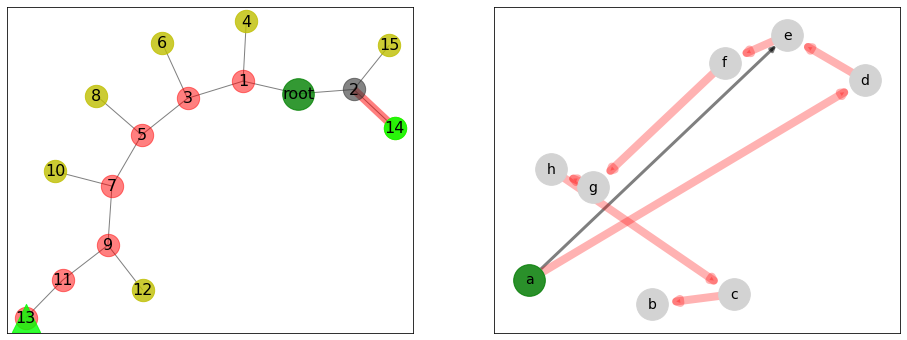

In [17]:
cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
parent = queue.pop()


if parent == 'break':
    print('END')
else:
    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)
    log_p = log_p.detach().numpy()
    sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    
    
    print('depth: ', sp.depth)
    
    plt.subplot(121)
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    colors = []
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node],                           
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    opt_nodes = [i for i in queue.nodes_opt if i!=sp]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=opt_nodes,
                           node_size = 500,                           
                           node_color='r',
                           alpha=0.5)
    
    in_queue = [i for i in queue.other_nodes if i in queue.queue]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=in_queue,
                           node_size = 500,
                           node_color='y',
                           alpha=0.8)
    
    out_of_queue = [i for i in queue.other_nodes if i not in queue.queue]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=out_of_queue,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(out_of_queue))],
                           alpha=0.6)    
            
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[sp],
                           node_size = 500,                           
                           node_color=[(0.0,1.0,0.0)],
                           alpha=0.8)
    """
    if first_direct and queue.t_direct != queue.t_opt:        
        first_direct = False
        direct = queue.t_direct
    """
    if queue.direct_node is not None:
        """
        if direct != queue.t_direct:
            direct = queue.t_direct
         
        """   
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='^',
                               node_size = 800,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8) 

            


    
    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color='r')

    
        
    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:        
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='g',min_target_margin=15)


    l = {i:abc[i] for i in range(x.size(1))}
    
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    last_parent = parent
    
    #nx.draw_networkx(cities,pos, edgelist=edgelist, node_size= 500, node_color='lightgrey' )
    

## Node size: 
##### max Gumbel
## Node color: 
##### epsilon(length + 2MST)

In [18]:
def make_circule(n):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    pos = nx.circular_layout(G, scale=0.5, center=(0.5,0.5))
    
    return torch.tensor([np.stack(list(pos.values()))], dtype = torch.float32)




In [19]:
def min_max_norm(x, a, b):
    min_x = np.min(x)
    max_x = np.max(x)
    return a + (((x - min_x)*(b-a))/(max_x - min_x))

def norm(x):
    return (x-np.mean(x))/np.std(x)

In [20]:
np.random.seed(4)
torch.manual_seed(4)
x = torch.rand(1, num_cities, 2)
# x = make_circule(num_cities)
#x = torch.load('good_example_8graph')


In [21]:
dirpg_opts.dynamic_weighting = False
dirpg_opts.dfs_like = True


dirpg = dirpg_m.DirPG(model, dirpg_opts)



In [22]:
queue,state, fixed = init_queue(x, dirpg, epsilon=1.0, alpha=0)
update = False
skip = True
direct, first_direct = None, True
parent = queue.pop()

t_opt: 
['a', 'e', 'h', 'd', 'g', 'f', 'b', 'c']
t_direct: 
['a', 'e', 'h', 'd', 'g', 'f', 'b', 'c']
special child prefix: 
['a', 'h', 'd']
prune count:  0
lower bound:  tensor([-48.0853])
candidates:  1
scecial child: 
 -----------    Node     -----------
id:   tensor(0)
first_a:   0
prefix:   [0, 7, 3]
not visited:   [1, 2, 4, 5, 6]
next_actions:   [1, 2, 4, 5, 6]
t:   3
distance matrix:
max_gumbel:   -1.6277575263585526
epsilon:    1.0
alpha:    0
alpha * len_togo:    tensor(-0.)
eps_reward:  tensor([-0.8932])
priority:  tensor([-2.5209])
objective:  tensor([-2.5209])
upper bound:  tensor([-2.5209])
lengths:   tensor([-0.8932])
bound length togo:  tensor(-1.0745)
done:   False
logprob_so_far:   -0.21976668760180473
t_opt:   False
 -------------------------------


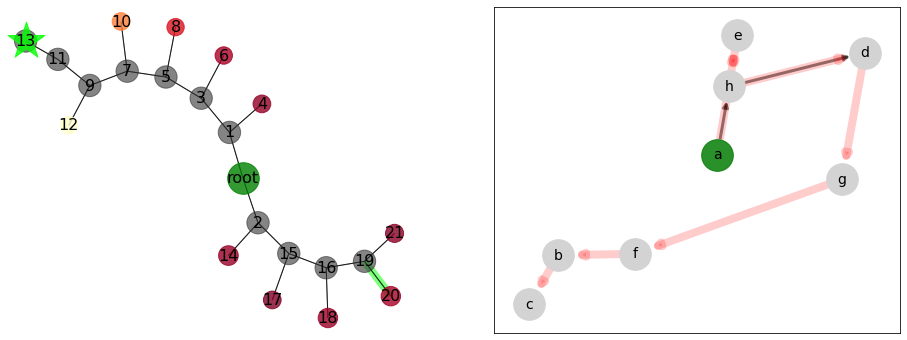

In [34]:
Node.budget = dirpg_opts.max_interactions
update = not update if not skip else skip


cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
if parent == 'break':
    print('END')
else:
    if update:        
        
        batch_state = state.stack_state([parent])
        log_p, state = dirpg.forward_and_update(batch_state, fixed)
        log_p = log_p.detach().numpy()
        sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
        
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    print('prune count: ', queue.prune_count)
    print('lower bound: ',queue.lower_bound )
    print('candidates: ',len(queue.trajectories_list) )
    print('scecial child: ')
    sp.print()
    #print('other children: ')
    #oth.print() if oth is not None else None    
    #print('scecial upper bound: ',sp.upper_bound)
    #print('others upper bound: ',oth.upper_bound) if oth is not None else None
    ax = plt.subplot(121)
    
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)

    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color=(0.0,1.0,0.0))
    """
    print('max_gumbel  +   eps*(- length - 2MST) = ')
    for i,j in zip([n.max_gumbel for n in queue.queue],
                  [Node.epsilon*n.get_upper_bound(2.0).item() for n in queue.queue]):
        
        print(i, ' +  ',j,  '  = ', i+j )
    """
    org_s = [n.max_gumbel for n in queue.queue]
    
    s2 = [300+400.0*np.exp(n.max_gumbel) for n in queue.queue]
    s_mm = min_max_norm(org_s, a=np.min(org_s) ,b=np.max([5000,np.max(org_s)]))
    s_n = 300+100*norm(org_s)

    colors = [n.eps_reward.item() for n in queue.queue]

    nx.draw(queue.G, pos,
        nodelist=queue.queue,
        node_size=s2,
        node_color=colors,
        cmap=plt.cm.YlOrRd,
        alpha=0.8)
    
    out_of_queue = [i for i in queue.G if i not in queue.queue if i != queue.root_node]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=out_of_queue,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(out_of_queue))],
                           alpha=0.6)
    
    if not update and not skip:
        parent = queue.pop()
        ax.set_facecolor(color='none')
        nx.draw_networkx_nodes(queue.G, pos,ax=ax,
                               nodelist=[parent], 
                               node_size = 4000,
                               node_color='none',
                               linewidths=3.0,
                               node_shape = matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'),
                               edgecolors='b')
    elif skip:
        parent = queue.pop()
    
    if queue.direct_node is not None:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='*',
                               node_size = 1500,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8)
            

    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.2, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.2, edge_color='g',min_target_margin=15)
        
        
        
    l = {i:abc[i] for i in range(x.size(1))}
    
  
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    
    

## DFS vs BFS

### DFS: Nodes that extends a prefix are colored orange 
### BFS: Nodes that search for actions other than the last node are colored blue 
### Nodes that explore different prefix are colored yellow 

In [24]:
plt.rcParams['figure.figsize'] = [16, 6]
np.random.seed(4)
torch.manual_seed(4)
x = torch.rand(1, num_cities, 2)
# x = make_circule(num_cities)
#x = torch.load('good_example_8graph')


In [18]:
queue,state, fixed = init_queue(x, dirpg, epsilon=10.0, alpha=5.0)
update = False
direct, first_direct = None, True
dfs, bfs, others = [],[],[]
last_parent = None

In [19]:
cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
parent = queue.pop()


if parent == 'break':
    print('END')
else:
    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    

    if last_parent is not None and parent not in queue.nodes_opt:

        if parent.prefix == last_parent.prefix:
            bfs.append(parent)
        elif parent.prefix[:-1] == last_parent.prefix:
            dfs.append(parent)
        else:
            others.append(parent)
        
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    
    print('depth: ', sp.depth)
    print('alpha: ', sp.alpha)
    
    plt.subplot(121)
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node],                           
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    opt_nodes = [i for i in queue.nodes_opt if i!=sp]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=queue.nodes_opt,
                           node_size = 500,                           
                           node_color='r',
                           alpha=0.5)
    
    others_nodes = [i for i in queue.other_nodes if i not in dfs+bfs+others]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=others_nodes,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(others_nodes))],
                           alpha=0.6) 
    
    if dfs:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=dfs,
                               node_size = 500,
                               node_color='orange',
                               alpha=0.8)
    if bfs:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=bfs,
                               node_size = 500,
                               node_color='blue',
                               alpha=0.6)  
    if others:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=others,
                               node_size = 500,
                               node_color='magenta',
                               alpha=0.6)             
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[sp],
                           node_size = 500,                           
                           node_color=[(0.0,1.0,0.0)],
                           alpha=0.8)
    """
    if first_direct and queue.t_direct != queue.t_opt:        
        first_direct = False
        direct = queue.t_direct
    """
    if queue.direct_node is not None:
        """
        if direct != queue.t_direct:
            direct = queue.t_direct
         
        """   
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='^',
                               node_size = 800,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8) 

            


    
    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color='r')

    
        
    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:        
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='g',min_target_margin=15)


    l = {i:abc[i] for i in range(x.size(1))}
    
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    last_parent = parent
    
    #nx.draw_networkx(cities,pos, edgelist=edgelist, node_size= 500, node_color='lightgrey' )
    

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [20]:
import mst

ModuleNotFoundError: No module named 'mst'

In [21]:
def generate_random_distance_matrix(n):
    loc = torch.FloatTensor(n, 2).uniform_(0, 1)
    return (loc[:, None, :] - loc[None, :, :]).norm(p=2, dim=-1)


In [22]:
a = generate_random_distance_matrix(6)
iu1 = np.triu_indices(6,k=1)
print(a)
print(a[iu1])


tensor([[0.0000, 0.8861, 0.0359, 0.6275, 0.3588, 0.8913],
        [0.8861, 0.0000, 0.9068, 0.4188, 0.7223, 0.0413],
        [0.0359, 0.9068, 0.0000, 0.6340, 0.3497, 0.9134],
        [0.6275, 0.4188, 0.6340, 0.0000, 0.3452, 0.4495],
        [0.3588, 0.7223, 0.3497, 0.3452, 0.0000, 0.7432],
        [0.8913, 0.0413, 0.9134, 0.4495, 0.7432, 0.0000]])
tensor([0.8861, 0.0359, 0.6275, 0.3588, 0.8913, 0.9068, 0.4188, 0.7223, 0.0413,
        0.6340, 0.3497, 0.9134, 0.3452, 0.4495, 0.7432])


In [23]:
def greedy_path(distance_matrix, prefix):
    M = np.inf
    cost = []
    path = []
    dest = prefix[0]
    current = prefix[-1]
    dm_copy = distance_matrix.copy()

    np.fill_diagonal(dm_copy, M)
    dm_copy[:,prefix[:-1]] = M
    dm_copy[prefix[:-1],:] = M

    while np.any(dm_copy != M):
        
        greedy = np.argmin(dm_copy[current])
        cost.append(dm_copy[current][greedy])
        path.append(greedy)
        dm_copy[:,current] = M
        dm_copy[current, :] = M
        current = greedy
        
    cost.append(distance_matrix[path[-1], dest])    
    return np.sum(cost)

print(greedy_path(a, [2,3]))

    
    

AttributeError: 'Tensor' object has no attribute 'copy'

In [24]:
class heap_wrapper:
    def __init__(self, instance, i):
        
        self.instance = instance
        self.i = i
    def __lt__(self, other):
        return self.i < other.i

def sample(queue,state,fixed):
    parent = queue.pop()
    if parent == 'break':
        return parent

    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    queue.expand(state[torch.tensor(0)], log_p[0])

def for_loop_version(batch):
    queues = [init_queue(x, dirpg) for x in batch]
    while queues:
        copy_queues = copy.copy(queues)
        for q in copy_queues:
            if sample(*q) == 'break':
                queues.remove(q)

def heap_version(batch):
    queues = [heap_wrapper(init_queue(x, dirpg),i) for i,x in enumerate(batch)]
    #heapq.heapify(queues)
    counter = len(batch)
    while queues:
        counter += 1 
        qw = heapq.heappop(queues)
        qw.i = counter
        q = qw.instance

        if sample(*q) != 'break':
            heapq.heappush(queues,qw)
        
            
        
    
    
def start_comparison:
    import copy
    batch_size = 200
    x = torch.rand(batch_size, 1,num_cities, 2)
    s = time.time()
    for_loop_version(x)
    d = time.time()
    heap_version(x)
    e = time.time()
    print('loop :', d-s )
    print('heap :', e-d )
    #heaps = [[] for _ in range(batch_size)]
    #heap = []

SyntaxError: invalid syntax (<ipython-input-24-84d4997737e2>, line 44)

In [25]:


def reduce_distance_matrix(x,nodes, prefix=True):
    """args: 
    x: distance metrix NxN
    nodes: list of nodes to remove or to keep depending on prefix arg
    prefix: if true"""
    
    if prefix:
        return np.delete(np.delete(x, nodes[1:], 0), nodes[1:], 1)
    
    else: # not_visited +
        ind = torch.tensor(nodes, dtype=torch.long)
        return torch.index_select(torch.index_select(x,0,ind),1,ind)
        
def reduced_val_mst(mst_val, mst_edges, prefix):
    m = mst_val.clone()
    for p in prefix:
        
        m -= mst_edges[p].sum()
    return m
    
    
#reduce_distance_matrix(generate_random_distance_matrix(5),[2,3], False)


## Compare MST to Reduced-MST

The root node of the priority queue computes the MST of the complete graph (n cities).
When the priority queue is expanded, the next node computes the MST of n-1 cities.

Here we compare two alternatives for estimating the MST starting from n to 1:
1. exact MST computation 
2. removing the chosen node and edges from the last MST


In [26]:
import scipy.sparse.csgraph as cs  
x = generate_random_distance_matrix(20)
mst_edges = mst.prim_pytorch(x)
mst_val = mst_edges.sum()
print(cs.minimum_spanning_tree(x))
reduced_val_mst(mst_val, mst_edges,[0,1,2,3,4])


  (0, 2)	0.07364742457866669
  (0, 15)	0.06627999246120453
  (1, 11)	0.1328587681055069
  (2, 7)	0.27351582050323486
  (3, 8)	0.048131030052900314
  (3, 15)	0.11203425377607346
  (5, 9)	0.16068178415298462
  (6, 16)	0.2402617335319519
  (7, 10)	0.03125007450580597
  (7, 18)	0.13067927956581116
  (8, 9)	0.1292407214641571
  (12, 10)	0.25045183300971985
  (13, 17)	0.22408105432987213
  (14, 12)	0.39458560943603516
  (14, 17)	0.19872558116912842
  (18, 6)	0.14018507301807404
  (19, 4)	0.10160967707633972
  (19, 11)	0.06295566260814667
  (19, 13)	0.1544581949710846


tensor(2.4641)

In [27]:
mst_val = mst_edges.sum()

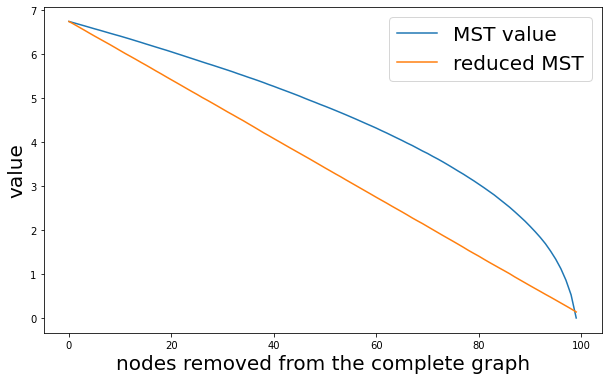

In [144]:
import matplotlib.pyplot as plt

n = 100
trials = 1000

mst_vals = torch.zeros(trials,n)
rmst_vals = torch.zeros(trials,n)
mod_rmst_vals = torch.zeros(trials,n)
coef = torch.tensor([1.6149683,  -1.5138257,  -0.00853372, -0.2192523 ])
intercept = 1.9495429
features = torch.zeros(n*trials,4) # complete mst, rmst, step (how much was already reduced)

for trial in range(trials):
    x = generate_random_distance_matrix(n)
    mst_edges = mst.prim_pytorch(x)
    mst_val = mst_edges.sum()
    
    prefix = []
    for i,chosen in enumerate(reversed(range(n))):
        exact_mst = mst.prim_pytorch(x).sum()
        rmst = reduced_val_mst(mst_val, mst_edges, prefix)
        prefix.append(chosen)
        not_visited = [j for j in range(n) if j not in prefix]
        x = reduce_distance_matrix(x,not_visited,False)
        
        mst_vals[trial,i] = exact_mst
        rmst_vals[trial,i] = rmst
        
        features[trial+i,0] = mst_val
        features[trial+i,1] = rmst
        features[trial+i,2] = torch.exp(rmst)
        features[trial+i,3] = float(i)
        mod_rmst_vals[trial,i] = torch.dot(torch.tensor([mst_val,rmst,torch.exp(rmst),float(i)]),coef) + intercept


diff = mst_vals-rmst_vals
mst_plot = mst_vals.mean(0).tolist()
rmst_plot = rmst_vals.mean(0).tolist()
mod_rmst_plot = mod_rmst_vals.mean(0).tolist()



diff_plot = diff.mean(0).tolist()


plt.figure(figsize=(10,6))
plt.plot(mst_plot)
plt.plot(rmst_plot)
#plt.plot(mod_rmst_plot)


plt.legend(['MST value', 'reduced MST'], fontsize=20) #, 'corrected MST after '
plt.ylabel('value', size=20)
plt.xlabel('nodes removed from the complete graph', size=20)

print()




Text(0.5, 0, 'nodes removed from the complete graph')

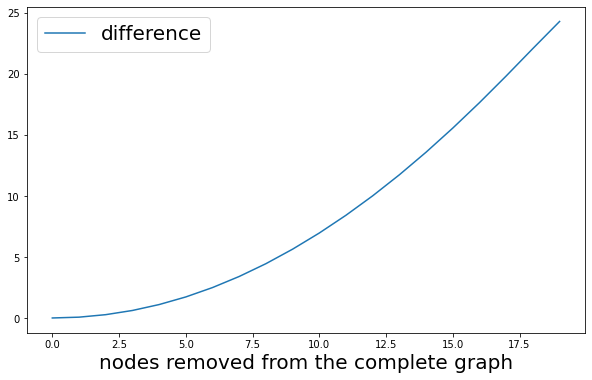

In [54]:
plt.figure(figsize=(10,6))
plt.plot(diff_plot)


plt.legend(['difference'], fontsize=20)
plt.xlabel('nodes removed from the complete graph', size=20)

In [141]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = features.numpy()
# y = 1 * x_0 + 2 * x_1 + 3
y = mst_vals.view(-1).numpy()
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

print(reg.coef_)
print(reg.intercept_)


0.0015889137060878245
[ 1.6149683  -1.5138257  -0.00853372 -0.2192523 ]
1.9495429


In [167]:
import heapq

class Kruskals:
    def __init__(self, distance_matrix):
        self.dm = distance_matrix
        self.n = distance_matrix.shape[0]
        self.edges_heap = []
        upper_trg_ind = np.triu_indices(self.n,k=1)
        edges_heap = distance_matrix[upper_trg_ind].tolist()
        for edges, n1, n2 in zip(edges_heap,*upper_trg_ind):
            self.edges_heap.append((edges, n1, n2))
        
        heapq.heapify(self.edges_heap)
        print(self.edges_heap)
        self.in_mst = set()
        self.out_mst = set()
        
        
        
        while len(self.in_mst) != self.n:
            distance, v, u = heapq.heappop(m.edges_heap)
            if 
            
            

m = Kruskals(generate_random_distance_matrix(4))

heapq.heappop(m.edges_heap)

tensor([[0.0000, 0.7291, 0.2108, 0.6283],
        [0.7291, 0.0000, 0.8548, 0.3251],
        [0.2108, 0.8548, 0.0000, 0.6759],
        [0.6283, 0.3251, 0.6759, 0.0000]])
[(0.21078051626682281, 0, 2), (0.32512038946151733, 1, 3), (0.6283052563667297, 0, 3), (0.8547717928886414, 1, 2), (0.7290551066398621, 0, 1), (0.6758912801742554, 2, 3)]


(0.21078051626682281, 0, 2)

In [157]:
np.triu_indices(6,k=1)

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4]),
 array([1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]))

In [28]:

def convert_distance_matrix_to_batched_edges(distance_matrix):
    """distance_matrix: batch of distance matrices. size: [batch, n, n]
    returns weights_and_edges: in shape (batch_size, n * (n - 1) / 2, 3), where
    weights_and_edges[.][i] = [weight_i, node1_i, node2_i] for edge i."""
    
    n = distance_matrix.shape[0]
    weights_and_edges = torch.zeros(1, n*(n-1)//2, 3)
    
    upper_trg_ind = np.triu_indices(n,k=1)
    edges_heap = distance_matrix[upper_trg_ind].tolist()
    """
    edges_heap = np.array([0.7601073, -0.20460297, -0.4689217, -0.5127163, 
                         -1.9022679, 1.1506207])
    """
    for i,(edges, n1, n2) in enumerate(zip(edges_heap,*upper_trg_ind)):
        weights_and_edges[0,i] = torch.tensor([edges, n1, n2])
        
    return weights_and_edges
    


In [29]:
n=5
print(np.triu_indices(n=n-1, m=n, k=1))
print(np.triu_indices(n,k=1))

(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([1, 2, 3, 4, 2, 3, 4, 3, 4, 4]))
(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([1, 2, 3, 4, 2, 3, 4, 3, 4, 4]))


In [129]:
weights = np.array([0.7601073, -0.20460297, -0.4689217, -0.5127163, 
                     -1.9022679, 1.1506207])
vertices = np.triu_indices(n=n-1, m=n, k=1)
weights_and_edges = np.array(
    [list(e) for e in zip(weights, vertices[0], vertices[1])])

weights_and_edges

array([[ 0.7601073 ,  0.        ,  1.        ],
       [-0.20460297,  0.        ,  2.        ],
       [-0.4689217 ,  0.        ,  3.        ],
       [-0.5127163 ,  0.        ,  4.        ],
       [-1.9022679 ,  1.        ,  2.        ],
       [ 1.1506207 ,  1.        ,  3.        ]])

In [64]:
import scipy.sparse.csgraph as cs  
from kruskals import kruskals as kks
n = 4
for _ in range(1):
    x = generate_random_distance_matrix(n)

    weights_and_edges = convert_distance_matrix_to_batched_edges(x) 
    print(weights_and_edges)
    res = kruskals_cpp.kruskals(weights_and_edges, n)
    print(cs.minimum_spanning_tree(x))
    # print(res)
    print(1 - kks.kruskals_cpp_pytorch(weights_and_edges, n))
    print('-------------------')
weights_and_edges.size()
res.size()

NameError: name 'generate_random_distance_matrix' is not defined

In [141]:
import random

np_time = 0
torch_time = 0
for i in range(5,20):
    prefix = random.sample(range(i), random.sample(range(1,i), 1)[0])
    not_visited = [j for j in range(i) if j not in prefix]
    a = generate_random_distance_matrix(i)
    s = time.time()
    reduce_distance_matrix(a,prefix, True)
    d = time.time()
    reduce_distance_matrix(a,not_visited, False)
    torch_time += (time.time() - d)
    np_time += (d-s)
    
print(torch_time)
print(np_time)

0.0010297298431396484
0.0021178722381591797


--no_progress_bar --graph_size 20  --not_prune --annealing 0.005 --epsilon 25 --alpha 1.5 --dynamic_weighting --exp_name bs200eps25alpha15ann005 --epoch_size 128000 --n_epochs 100 --batch_size 200



In [10]:
import numpy as np
import time
import torch
import kruskals_cpp
import scipy.sparse.csgraph as cs

In [11]:
def generate_random_distance_matrix(n):
    loc = torch.FloatTensor(n, 2).uniform_(0, 1)
    return (loc[:, None, :] - loc[None, :, :]).norm(p=2, dim=-1)



def convert_distance_matrix_to_batched_edges(distance_matrix):
    """distance_matrix: batch of distance matrices. size: [batch, n, n]
    returns weights_and_edges: in shape (batch_size, n * (n - 1) / 2, 3), where
    weights_and_edges[.][i] = [weight_i, node1_i, node2_i] for edge i."""
    
    n = distance_matrix.shape[0]
    weights_and_edges = torch.zeros(1, n*(n-1)//2, 3)
    
    upper_trg_ind = np.triu_indices(n,k=1)
    edges_heap = distance_matrix[upper_trg_ind].tolist()

    for i,(edges, n1, n2) in enumerate(zip(edges_heap,*upper_trg_ind)):
        weights_and_edges[0,i] = torch.tensor([edges, n1, n2])
        
    return weights_and_edges
    



In [21]:
n = 6
cpp_time = []
sc_time = []
for _ in range(1):
    x = generate_random_distance_matrix(n)

    weights_and_edges = convert_distance_matrix_to_batched_edges(x)
    print(weights_and_edges)
    sorted_weights = torch.argsort(weights_and_edges[:, :, 0], -1, descending=False)
    
    dummy = sorted_weights.unsqueeze(2).expand(*(sorted_weights.shape + (weights_and_edges.size(2),)))
    # sorted_edges is shape (batch_size, n * (n - 1) / 2, 2)
    sorted_edges = torch.gather(weights_and_edges, 1, dummy)

    #adj_mat = kruskals_cpp.get_tree(sorted_edges[:, :, 1:].int(), n, True)
    s = time.time()
    print(sorted_edges)
    edges_idx = kruskals_cpp.get_tree(sorted_edges[:, :, 1:].int(), n, False)
    print(edges_idx)
    cpp_val = sorted_edges[:, :, 0][edges_idx.bool()].sum()

    m = time.time()
    sc_res = cs.minimum_spanning_tree(x)
    print(sc_res)
    sc_val = sc_res.sum()
    cpp_time.append(cpp_val)
    sc_time.append(sc_val)
    print('val cpp: {}, time: {}'.format(cpp_val, m-s ))
    print('val scipy: {}, time: {}'.format(sc_val, time.time()-m))
    



#


#weights_and_edges[.bool()]

tensor([[[0.7211, 0.0000, 1.0000],
         [0.6556, 0.0000, 2.0000],
         [1.1170, 0.0000, 3.0000],
         [0.5170, 0.0000, 4.0000],
         [0.6556, 0.0000, 5.0000],
         [0.9401, 1.0000, 2.0000],
         [0.7279, 1.0000, 3.0000],
         [0.5767, 1.0000, 4.0000],
         [0.9726, 1.0000, 5.0000],
         [0.8150, 2.0000, 3.0000],
         [0.3638, 2.0000, 4.0000],
         [0.0430, 2.0000, 5.0000],
         [0.6229, 3.0000, 4.0000],
         [0.8577, 3.0000, 5.0000],
         [0.3977, 4.0000, 5.0000]]])
tensor([[[0.0430, 2.0000, 5.0000],
         [0.3638, 2.0000, 4.0000],
         [0.3977, 4.0000, 5.0000],
         [0.5170, 0.0000, 4.0000],
         [0.5767, 1.0000, 4.0000],
         [0.6229, 3.0000, 4.0000],
         [0.6556, 0.0000, 2.0000],
         [0.6556, 0.0000, 5.0000],
         [0.7211, 0.0000, 1.0000],
         [0.7279, 1.0000, 3.0000],
         [0.8150, 2.0000, 3.0000],
         [0.8577, 3.0000, 5.0000],
         [0.9401, 1.0000, 2.0000],
         [0.9726, 

In [71]:
class kruskals:
    def __init__(self, distance_matrix):
        self.weights_and_edges = self.sort_edges(self.convert_distance_matrix_to_batched_edges(distance_matrix))
        print(self.weights_and_edges)
        idx_in_sorted = [[] for _ in range(distance_matrix.shape[0])]
        for idx,(w,i,j) in enumerate(self.weights_and_edges[0].int()):
            idx_in_sorted[i].append(idx)
            idx_in_sorted[j].append(idx)
            
        print(idx_in_sorted)
        
        self.idx_in_sorted = np.array(idx_in_sorted)

    def compute_mst(self, not_visited):
        
        #reduced_sorted_wae = self.weights_and_edges[:,self.idx_in_sorted[not_visited]] if len(not_visited) > 0 else self.weights_and_edges 
        print(self.weights_and_edges.size())
        print(not_visited)
        idx = np.take(self.idx_in_sorted, not_visited, 0)
        reduced_sorted_wae =self.weights_and_edges[0][idx]
        print(reduced_sorted_wae)
        edges_idx = kruskals_cpp.get_tree(reduced_sorted_wae[:, :, 1:].int(), n, False)
        return reduced_sorted_wae[:, :, 0][edges_idx.bool()].sum()



    @staticmethod
    def sort_edges(weights_and_edges):
        sorted_weights = torch.argsort(weights_and_edges[:, :, 0], -1, descending=False)
        dummy = sorted_weights.unsqueeze(2).expand(*(sorted_weights.shape + (weights_and_edges.size(2),)))
        # sorted_edges is shape (batch_size, n * (n - 1) / 2, 2)
        return torch.gather(weights_and_edges, 1, dummy)

    @staticmethod
    def convert_distance_matrix_to_batched_edges(distance_matrix):
        """distance_matrix: batch of distance matrices. size: [batch, n, n]
        returns weights_and_edges: in shape (batch_size, n * (n - 1) / 2, 3), where
        weights_and_edges[.][i] = [weight_i, node1_i, node2_i] for edge i."""

        n = distance_matrix.shape[0]
        weights_and_edges = torch.zeros(1, n * (n - 1) // 2, 3)

        upper_trg_ind = np.triu_indices(n, k=1)
        edges_heap = distance_matrix[upper_trg_ind].tolist()

        for i, (edges, n1, n2) in enumerate(zip(edges_heap, *upper_trg_ind)):
            weights_and_edges[0, i] = torch.tensor([edges, n1, n2])
        print(weights_and_edges)
        return weights_and_edges


In [72]:
n=5
x = generate_random_distance_matrix(n)
krus = kruskals(x)
krus.compute_mst([2,3])

tensor([[[0.4998, 0.0000, 1.0000],
         [0.6568, 0.0000, 2.0000],
         [0.7265, 0.0000, 3.0000],
         [0.7650, 0.0000, 4.0000],
         [0.7776, 1.0000, 2.0000],
         [1.0484, 1.0000, 3.0000],
         [0.8471, 1.0000, 4.0000],
         [0.3981, 2.0000, 3.0000],
         [0.1114, 2.0000, 4.0000],
         [0.4513, 3.0000, 4.0000]]])
tensor([[[0.1114, 2.0000, 4.0000],
         [0.3981, 2.0000, 3.0000],
         [0.4513, 3.0000, 4.0000],
         [0.4998, 0.0000, 1.0000],
         [0.6568, 0.0000, 2.0000],
         [0.7265, 0.0000, 3.0000],
         [0.7650, 0.0000, 4.0000],
         [0.7776, 1.0000, 2.0000],
         [0.8471, 1.0000, 4.0000],
         [1.0484, 1.0000, 3.0000]]])
[[3, 4, 5, 6], [3, 7, 8, 9], [0, 1, 4, 7], [1, 2, 5, 9], [0, 2, 6, 8]]
torch.Size([1, 10, 3])
[2, 3]


IndexError: index 5 is out of bounds for dimension 1 with size 3

array([[0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
#include "ATen/Parallel.h"
#include <torch/extension.h>
#include <iostream>
#include <vector>
#include <memory>
#include <unordered_map>
//#include <pybind11/stl.h>
//#include <pybind11/complex.h>
//#include <pybind11/functional.h>
namespace py = pybind11;

using namespace std;

class BatchedGraphs{
    BatchedGraphs(torch::Tensor distance_matrices){

    }

};

struct NodeConverter;
struct HeapNode {
    float priority;
    bool t_opt;
    bool done;
    NodeConverter *converter;
    py::object python_node_object;
    int idx_original;

    ~HeapNode(){}
    HeapNode(pair<py::list, NodeConverter*> const node_args_pair){
        py::list node_args = node_args_pair.first;
        converter = node_args_pair.second;
        priority = node_args[0].cast<float>();
        t_opt = node_args[1].cast<bool>();
        done = node_args[2].cast<bool>();
        python_node_object = node_args[3];
        idx_original = node_args[4].cast<int>();
        //py::list batched_prefix(python_node_object.attr("prefix"));


    }
    HeapNode(const HeapNode &other){
        priority = other.priority;
        t_opt = other.t_opt;
        python_node_object = other.python_node_object;
        idx_original = other.idx_original;
        converter = other.converter;
        done = other.done;
    }
    /*
    HeapNode(HeapNode &&other){
        priority = other.priority;
        t_opt = other.t_opt;
        python_node_object = other.python_node_object;
        idx_original = other.idx_original;
        converter = other.converter;
        done = other.done;
    }
    */
    bool operator<(const HeapNode &other) const {
         if (t_opt == other.t_opt){
            return priority < other.priority;
         }
         if (t_opt && !other.t_opt){
            return false;
         }
         else{
            return true;
         }
    }
};


struct NodeConverter{

    torch::Tensor priority;
    torch::Tensor t_opt;
    torch::Tensor done;
    py::object python_object;
    torch::Tensor ids;

    torch::Tensor t;
    torch::Tensor next_actions;
    torch::Tensor not_visited;
    torch::Tensor prefix;
    torch::Tensor lengths;
    torch::Tensor cur_coord;

    torch::Tensor logprob_so_far;
    torch::Tensor bound_togo;
    torch::Tensor max_gumbel;

    NodeConverter(torch::Tensor _priority, torch::Tensor _t_opt, torch::Tensor _done, torch::Tensor _ids,
                  torch::Tensor _t, torch::Tensor _next_actions, torch::Tensor _not_visited, torch::Tensor _prefix,
                  torch::Tensor _lengths, torch::Tensor _cur_coord, torch::Tensor _logprob_so_far, torch::Tensor _bound_togo,
                  torch::Tensor _max_gumbel, py::object _python_object)
    {
        priority = _priority;
        t_opt = _t_opt;
        done = _done;
        ids = _ids;
        t = _t;
        next_actions = _next_actions;
        not_visited = _not_visited;
        prefix = _prefix;
        lengths = _lengths;
        cur_coord = _cur_coord;
        logprob_so_far = _logprob_so_far;
        bound_togo = _bound_togo;
        max_gumbel = _max_gumbel;
        python_object = _python_object;

    };

    pair<py::list, NodeConverter*> operator[] (int i) {
        // const NodeConverter *converter_object = this;
        py::list all_attrs;
        all_attrs.append(priority[i].item<float>());
        all_attrs.append(t_opt[i].item<bool>());
        all_attrs.append(done[i].item<bool>());
        all_attrs.append(python_object);
        all_attrs.append(ids[i].item<int>());

        pair<py::list,  NodeConverter*> ret(all_attrs, this);
        //ret = make_pair(all_attrs, this);
        return ret;
    }
};


struct Trajectory{
    int idx;
    py::object actions;  //this is actually a tensor
    float cost;
    float objective;

    Trajectory(HeapNode leaf_node){
        py::list batch_objective(leaf_node.python_node_object.attr("objective"));
        py::list batch_lengths(leaf_node.python_node_object.attr("lengths"));
        py::list batch_actions(leaf_node.python_node_object.attr("prefix"));

        idx = leaf_node.idx_original;
        objective = batch_objective[idx].cast<float>();
        cost = batch_lengths[idx].cast<float>();
        actions = batch_actions[idx];
    }
};

class Heap {
 private:
    std::vector<HeapNode> elements_;
 public:
    Heap(HeapNode new_node){

        elements_.push_back(new_node);
        push_heap(elements_.begin(), elements_.end());
    };
    void push(HeapNode new_node) {

        elements_.push_back(new_node);
        push_heap(elements_.begin(), elements_.end());
    }

    HeapNode pop() {
        HeapNode result = elements_.front();
        pop_heap(elements_.begin(), elements_.end());

        elements_.pop_back();
        return result;
    }

    bool is_empty() {
        return elements_.empty();
    };
};
/*
vector<torch::Tensor> stack_heap_nodes_vec(vector<HeapNode> heap_nodes,
                                                                      int batch_size,
                                                                      int graph_size){
    //set<NodeConverter*> to_remove;
    torch::Tensor ids = torch::zeros({batch_size,1}, torch::dtype(torch::kInt64).requires_grad(false));
    torch::Tensor t = torch::zeros({batch_size,1}, torch::dtype(torch::kInt64).requires_grad(false));
    torch::Tensor next_actions = torch::zeros({batch_size,1,graph_size}, torch::dtype(torch::kUInt8).requires_grad(false));
    torch::Tensor not_visited = torch::zeros({batch_size,1,graph_size}, torch::dtype(torch::kUInt8).requires_grad(false));
    torch::Tensor prefix = torch::zeros({batch_size,graph_size}, torch::dtype(torch::kInt64).requires_grad(false));
    torch::Tensor lengths = torch::zeros({batch_size,1});
    torch::Tensor cur_coord = torch::zeros({batch_size,1,2});
    torch::Tensor done = torch::zeros({batch_size,1}, torch::dtype(torch::kUInt8).requires_grad(false));
    torch::Tensor logprob_so_far = torch::zeros({batch_size,1});
    torch::Tensor bound_togo = torch::zeros({batch_size,1});
    torch::Tensor max_gumbel = torch::zeros({batch_size,1});
    torch::Tensor is_t_opt = torch::zeros({batch_size}, torch::dtype(torch::kUInt8).requires_grad(false));

    for (int i=0; i < batch_size; i++){
        //NodeConverter conv = heap_nodes[i].converter;
        ids[i] = heap_nodes[i].converter -> ids[i];
        t[i] = heap_nodes[i].converter -> t[i];
        next_actions[i] = heap_nodes[i].converter -> next_actions[i];
        not_visited[i] = heap_nodes[i].converter -> not_visited[i];
        prefix[i] = heap_nodes[i].converter -> prefix[i];
        lengths[i] = heap_nodes[i].converter -> lengths[i];
        cur_coord[i] = heap_nodes[i].converter -> cur_coord[i];
        done[i] = heap_nodes[i].converter -> done[i];
        logprob_so_far[i] = heap_nodes[i].converter -> logprob_so_far[i];
        bound_togo[i] = heap_nodes[i].converter -> bound_togo[i];
        max_gumbel[i] =heap_nodes[i].converter -> max_gumbel[i];
        is_t_opt[i] = heap_nodes[i].converter -> t_opt[i];
        //to_remove.insert(heap_nodes[i].converter);
    }

    vector<torch::Tensor> tensors {ids, t, next_actions, not_visited, prefix, lengths, cur_coord, done,
                                     logprob_so_far, bound_togo, max_gumbel, is_t_opt};

    //pair<vector<torch::Tensor>, set<NodeConverter*>> to_return (tensors, to_remove);
    return move(tensors);
}
*/


class BatchedHeaps{
    private:
        int batch_size = 100;
        int graph_size = 20;
        unordered_map< NodeConverter*, int> conv_objects;
        //py::dict conv_objects;
    public:
        vector<Heap> heaps_;
        BatchedHeaps(NodeConverter &root_node_conv , int batch_size_, int graph_size_){
            batch_size = batch_size_;
            graph_size = graph_size_;
            //conv_objects.insert(make_pair(root_node_conv, batch_size));
            //py::list l = {root_node_conv,batch_size };
            //conv_objects.append(l)
            //conv_objects[root_node_conv] = batch_size;
            for (int sample_idx=0; sample_idx < batch_size; sample_idx++){
                //auto new_node = make_shared<HeapNode>(root_nodes[sample_idx]);
                pair<py::list, NodeConverter*> conv_i = root_node_conv[sample_idx];
                if (sample_idx==0){conv_objects.insert(make_pair(conv_i.second, batch_size));}
                heaps_.push_back(Heap(HeapNode(conv_i)));
            }
        };

        py::list pop_batch(){
            //vector<NodeConverter*> converters_to_remove;
            py::list trajectories;
            py::list to_return;

            //////////////////////////////////////////////
            torch::Tensor ids = torch::zeros({batch_size,1}, torch::dtype(torch::kInt64).requires_grad(false));
            torch::Tensor t = torch::zeros({batch_size,1}, torch::dtype(torch::kInt64).requires_grad(false));
            torch::Tensor next_actions = torch::zeros({batch_size,1,graph_size}, torch::dtype(torch::kUInt8).requires_grad(false));
            torch::Tensor not_visited = torch::zeros({batch_size,1,graph_size}, torch::dtype(torch::kUInt8).requires_grad(false));
            torch::Tensor prefix = torch::zeros({batch_size,graph_size}, torch::dtype(torch::kInt64).requires_grad(false));
            torch::Tensor lengths = torch::zeros({batch_size,1});
            torch::Tensor cur_coord = torch::zeros({batch_size,1,2});
            torch::Tensor done = torch::zeros({batch_size,1}, torch::dtype(torch::kUInt8).requires_grad(false));
            torch::Tensor logprob_so_far = torch::zeros({batch_size,1});
            torch::Tensor bound_togo = torch::zeros({batch_size,1});
            torch::Tensor max_gumbel = torch::zeros({batch_size,1});
            torch::Tensor is_t_opt = torch::zeros({batch_size}, torch::dtype(torch::kUInt8).requires_grad(false));
            //////////////////////////////////////////////

            for (int i=0; i < batch_size; i++){
                bool to_repop = true; //!heaps_[sample_idx].is_empty();
                while (to_repop){
                    auto node(heaps_[i].pop());
                    to_repop = node.done;
                    if(to_repop){
                        Trajectory traj(node);
                        trajectories.append(traj);
                        }
                    else{
                        ids[i] = node.converter -> ids[i];
                        t[i] = node.converter -> t[i];
                        next_actions[i] = node.converter -> next_actions[i];
                        not_visited[i] = node.converter -> not_visited[i];
                        prefix[i] = node.converter -> prefix[i];
                        lengths[i] = node.converter -> lengths[i];
                        cur_coord[i] = node.converter -> cur_coord[i];
                        done[i] = node.converter -> done[i];
                        logprob_so_far[i] =node.converter -> logprob_so_far[i];
                        bound_togo[i] =node.converter -> bound_togo[i];
                        max_gumbel[i] =node.converter -> max_gumbel[i];
                        is_t_opt[i] = node.converter -> t_opt[i];
                        //to_remove.insert(node.converter);

                        conv_objects[node.converter] -= 1;
                        if (conv_objects[node.converter]  == 0)
                            conv_objects.erase(node.converter);

                     }
                }
            }
            vector<torch::Tensor> tensors {ids, t, next_actions, not_visited, prefix, lengths, cur_coord, done,
                                           logprob_so_far, bound_togo, max_gumbel, is_t_opt};

            to_return.append(tensors);
            to_return.append(trajectories);
            return to_return;
        }

        void push_batch(NodeConverter &node_conv , torch::Tensor ignore_list){
            for (int sample_idx=0; sample_idx < batch_size; sample_idx++){
                if (!ignore_list[sample_idx].item<bool>()){
                    pair<py::list, NodeConverter*> conv_i = node_conv[sample_idx];
                    if (sample_idx==0){conv_objects.insert(make_pair(conv_i.second, batch_size));}
                    heaps_[sample_idx].push(conv_i);
                    }
            }
        }
        void push_batch(NodeConverter &node_conv){
            for (int sample_idx=0; sample_idx < batch_size; sample_idx++){
                pair<py::list, NodeConverter*> conv_i = node_conv[sample_idx];
                if (sample_idx==0){conv_objects.insert(make_pair(conv_i.second, batch_size));}
                heaps_[sample_idx].push(conv_i);
            }
        }
        int size(){
            return heaps_.size();
        }
};

std::unique_ptr<NodeConverter> convert_python_to_cpp(torch::Tensor _priority, torch::Tensor _t_opt, torch::Tensor _done, torch::Tensor _ids,
                  torch::Tensor _t, torch::Tensor _next_actions, torch::Tensor _not_visited, torch::Tensor _prefix,
                  torch::Tensor _lengths, torch::Tensor _cur_coord, torch::Tensor _logprob_so_far, torch::Tensor _bound_togo,
                  torch::Tensor _max_gumbel, py::object _python_object) {

    return std::unique_ptr<NodeConverter>(new NodeConverter(_priority,_t_opt,_done,_ids,_t,_next_actions,_not_visited,
                    _prefix,_lengths,_cur_coord,_logprob_so_far,_bound_togo,_max_gumbel,_python_object));
 }

namespace py = pybind11;
PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  //m.def("stack_heap_nodes_vec", &stack_heap_nodes_vec);
  m.def("convert_python_to_cpp", &convert_python_to_cpp);
  py::class_<BatchedHeaps>(m, "BatchedHeaps") // returns BatchedHeapNode
      .def(py::init<NodeConverter&, int, int>(), py::keep_alive<1, 2>()) // py::return_value_policy::take_ownership
      //.def(py::init<py::object>())
      .def("pop_batch", &BatchedHeaps::pop_batch)
      .def("push_batch",(void (BatchedHeaps::*)(NodeConverter&)) &BatchedHeaps::push_batch)
      .def("push_batch",(void (BatchedHeaps::*)(NodeConverter&, torch::Tensor)) &BatchedHeaps::push_batch)


      .def("size", &BatchedHeaps::size)
      .def_readonly("heaps_", &BatchedHeaps::heaps_);

  py::class_<HeapNode>(m, "HeapNode")
      //.def(py::init<double,double,bool,double>())
      .def(py::init<pair<py::list, NodeConverter*>>())
      .def_readwrite("python_node_object", &HeapNode::python_node_object)
      .def_readwrite("priority", &HeapNode::priority)
      .def_readwrite("done", &HeapNode::done)
      .def_readwrite("idx_original", &HeapNode::idx_original)
      .def_readwrite("t_opt", &HeapNode::t_opt);


  py::class_<Trajectory>(m, "Trajectory")
      //.def(py::init<HeapNode>())
      .def_readonly("idx", &Trajectory::idx)
      .def_readonly("actions", &Trajectory::actions)
      .def_readonly("cost", &Trajectory::cost)
      .def_readonly("objective", &Trajectory::objective);
  /*
  py::class_<Heap>(m, "Heap")
      .def(py::init<HeapNode*>())
      //.def("get_elements_", &Heap::get_elements_)
      .def("push", &Heap::push)
      .def("pop", &Heap::pop) //
      .def("is_empty", &Heap::is_empty); //pybind11::return_value_policy::move
  */
  py::class_<NodeConverter>(m, "NodeConverter")
      .def(py::init<torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,
       torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor, py::object>())
      .def_readwrite("priority", &NodeConverter::priority)
      .def_readwrite("t_opt", &NodeConverter::t_opt)
      .def_readwrite("done", &NodeConverter::done)
      .def_readwrite("ids", &NodeConverter::ids)
      .def_readwrite("t", &NodeConverter::t)
      .def_readwrite("next_actions", &NodeConverter::next_actions)
      .def_readwrite("not_visited", &NodeConverter::not_visited)
      .def_readwrite("prefix", &NodeConverter::prefix)
      .def_readwrite("lengths", &NodeConverter::lengths)
      .def_readwrite("cur_coord", &NodeConverter::cur_coord)
      .def_readwrite("logprob_so_far", &NodeConverter::logprob_so_far)
      .def_readwrite("bound_togo", &NodeConverter::bound_togo)
      .def_readwrite("max_gumbel", &NodeConverter::max_gumbel);

}


In [ ]:
class BatchedMST{
    BatchedGraphs graphs;
    int batch_size;
    int graph_size;
    public:
    BatchedMST(int batch_size_, int graph_size_):graphs{batch_size_,graph_size_}{ // , torch::Tensor batched_distance_matrix
        //graphs = BatchedGraphs(batch_size_, graph_size_);
        batch_size=batch_size_;
        graph_size=graph_size_;
    }

    void set_node_attr(CppTspNode *cpp_node, )



};

In [ ]:
#include "ATen/Parallel.h"
#include <torch/extension.h>
#include <iostream>
#include <vector>
#include <memory>

//#include <pybind11/stl.h>
//#include <pybind11/complex.h>
//#include <pybind11/functional.h>

using namespace std;

class BatchedGraphs{
    BatchedGraphs(torch::Tensor distance_matrices){

    };

};

struct NodeConverter;

struct HeapNode {
    float priority;
    bool t_opt;
    bool done;
    NodeConverter *converter;
    py::object python_node_object;
    int idx_original;

    ~HeapNode(){};
    HeapNode(pair<py::list, NodeConverter*> const node_args_pair){
        py::list node_args = node_args_pair.first;
        converter = node_args_pair.second;
        priority = node_args[0].cast<float>();
        t_opt = node_args[1].cast<bool>();
        done = node_args[2].cast<bool>();
        python_node_object = node_args[3];
        idx_original = node_args[4].cast<int>();
        //py::list batched_prefix(python_node_object.attr("prefix"));


    }
    HeapNode(const HeapNode &other){
        priority = other.priority;
        t_opt = other.t_opt;
        python_node_object = other.python_node_object;
        idx_original = other.idx_original;
        converter = other.converter;
        done = other.done;
    }
    /*
    HeapNode(HeapNode &&other){
        priority = other.priority;
        t_opt = other.t_opt;
        python_node_object = other.python_node_object;
        idx_original = other.idx_original;
        converter = other.converter;
        done = other.done;
    }
    */
    bool operator<(const HeapNode &other) const {
         if (t_opt == other.t_opt){
            return priority < other.priority;
         }
         if (t_opt && !other.t_opt){
            return false;
         }
         else{
            return true;
         }
    }
};

struct NodeConverter{

    torch::Tensor priority;
    torch::Tensor t_opt;
    torch::Tensor done;
    py::object python_object;
    torch::Tensor ids;

    torch::Tensor t;
    torch::Tensor next_actions;
    torch::Tensor not_visited;
    torch::Tensor prefix;
    torch::Tensor lengths;
    torch::Tensor cur_coord;

    torch::Tensor logprob_so_far;
    torch::Tensor bound_togo;
    torch::Tensor max_gumbel;

    NodeConverter(torch::Tensor _priority, torch::Tensor _t_opt, torch::Tensor _done, torch::Tensor _ids,
                  torch::Tensor _t, torch::Tensor _next_actions, torch::Tensor _not_visited, torch::Tensor _prefix,
                  torch::Tensor _lengths, torch::Tensor _cur_coord, torch::Tensor _logprob_so_far, torch::Tensor _bound_togo,
                  torch::Tensor _max_gumbel, py::object _python_object)
    {
        priority = _priority;
        t_opt = _t_opt;
        done = _done;
        ids = _ids;
        t = _t;
        next_actions = _next_actions;
        not_visited = _not_visited;
        prefix = _prefix;
        lengths = _lengths;
        cur_coord = _cur_coord;
        logprob_so_far = _logprob_so_far;
        bound_togo = _bound_togo;
        max_gumbel = _max_gumbel;
        python_object = _python_object;

    };

    pair<py::list, NodeConverter*> operator[] (int i) {
        // const NodeConverter *converter_object = this;
        py::list all_attrs;
        all_attrs.append(priority[i].item<float>());
        all_attrs.append(t_opt[i].item<bool>());
        all_attrs.append(done[i].item<bool>());
        all_attrs.append(python_object);
        all_attrs.append(ids[i].item<int>());

        pair<py::list,  NodeConverter*> ret(all_attrs, this);
        //ret = make_pair(all_attrs, this);
        return ret;
    }
};


struct Trajectory{
    int idx;
    py::object actions;  //this is actually a tensor
    float cost;
    float objective;

    Trajectory(HeapNode leaf_node){
        py::list batch_objective(leaf_node.python_node_object.attr("objective"));
        py::list batch_lengths(leaf_node.python_node_object.attr("lengths"));
        py::list batch_actions(leaf_node.python_node_object.attr("prefix"));

        idx = leaf_node.idx_original;
        objective = batch_objective[idx].cast<float>();
        cost = batch_lengths[idx].cast<float>();
        actions = batch_actions[idx];
    }
};

class Heap {
 private:
    std::vector<HeapNode> elements_;
 public:
    Heap(HeapNode new_node){

        elements_.push_back(new_node);
        push_heap(elements_.begin(), elements_.end());
    };
    void push(HeapNode new_node) {

        elements_.push_back(new_node);
        push_heap(elements_.begin(), elements_.end());
    }

    HeapNode pop() {
        HeapNode result = elements_.front();
        pop_heap(elements_.begin(), elements_.end());

        elements_.pop_back();
        return result;
    }

    bool is_empty() {
        return elements_.empty();
    };
};

void clearVectorContents( std::vector <HeapNode*> & a )
{
    for ( int i = 0; i < a.size(); i++ )
    {
        delete a[i];
    }
    a.clear();
}


pair<vector<torch::Tensor>, set<NodeConverter*>> stack_heap_nodes_vec(vector<HeapNode> heap_nodes,
                                                                      int batch_size,
                                                                      int graph_size){
    set<NodeConverter*> to_remove;
    torch::Tensor ids = torch::zeros({batch_size,1}, torch::dtype(torch::kInt64).requires_grad(false));
    torch::Tensor t = torch::zeros({batch_size,1}, torch::dtype(torch::kInt64).requires_grad(false));
    torch::Tensor next_actions = torch::zeros({batch_size,1,graph_size}, torch::dtype(torch::kUInt8).requires_grad(false));
    torch::Tensor not_visited = torch::zeros({batch_size,1,graph_size}, torch::dtype(torch::kUInt8).requires_grad(false));
    torch::Tensor prefix = torch::zeros({batch_size,graph_size}, torch::dtype(torch::kInt64).requires_grad(false));
    torch::Tensor lengths = torch::zeros({batch_size,1});
    torch::Tensor cur_coord = torch::zeros({batch_size,1,2});
    torch::Tensor done = torch::zeros({batch_size,1}, torch::dtype(torch::kUInt8).requires_grad(false));
    torch::Tensor logprob_so_far = torch::zeros({batch_size,1});
    torch::Tensor bound_togo = torch::zeros({batch_size,1});
    torch::Tensor max_gumbel = torch::zeros({batch_size,1});
    torch::Tensor is_t_opt = torch::zeros({batch_size}, torch::dtype(torch::kUInt8).requires_grad(false));

    for (int i=0; i < batch_size; i++){
        //NodeConverter conv = heap_nodes[i].converter;
        ids[i] = heap_nodes[i].converter -> ids[i];
        t[i] = heap_nodes[i].converter -> t[i];
        next_actions[i] = heap_nodes[i].converter -> next_actions[i];
        not_visited[i] = heap_nodes[i].converter -> not_visited[i];
        prefix[i] = heap_nodes[i].converter -> prefix[i];
        lengths[i] = heap_nodes[i].converter -> lengths[i];
        cur_coord[i] = heap_nodes[i].converter -> cur_coord[i];
        done[i] = heap_nodes[i].converter -> done[i];
        logprob_so_far[i] = heap_nodes[i].converter -> logprob_so_far[i];
        bound_togo[i] = heap_nodes[i].converter -> bound_togo[i];
        max_gumbel[i] =heap_nodes[i].converter -> max_gumbel[i];
        is_t_opt[i] = heap_nodes[i].converter -> t_opt[i];
        to_remove.insert(heap_nodes[i].converter);
    }

    vector<torch::Tensor> tensors {ids, t, next_actions, not_visited, prefix, lengths, cur_coord, done,
                                     logprob_so_far, bound_togo, max_gumbel, is_t_opt};

    pair<vector<torch::Tensor>, set<NodeConverter*>> to_return (tensors, to_remove);
    return to_return;
}



class BatchedHeaps{
    private:
        int batch_size_ = 100;
        int graph_size_ = 20;
    public:
        vector<Heap> heaps_;
        BatchedHeaps(NodeConverter &root_nodes, int batch_size, int graph_size){
            batch_size_ = batch_size;
            graph_size_ = graph_size;
            for (int sample_idx=0; sample_idx < batch_size_; sample_idx++){
                //auto new_node = make_shared<HeapNode>(root_nodes[sample_idx]);
                //heaps_.push_back(Heap(new_node));

                heaps_.push_back(Heap(HeapNode(root_nodes[sample_idx])));
            }
        };

        py::list pop_batch(){
            vector<HeapNode> heap_nodes;
            vector<NodeConverter*> converters_to_remove;
            py::list trajectories;
            py::list to_return;

            for (int sample_idx=0; sample_idx < batch_size_; sample_idx++){
                bool to_repop = true; //!heaps_[sample_idx].is_empty();
                while (to_repop){
                    auto node(heaps_[sample_idx].pop());
                    to_repop = node.done;
                    if(to_repop){
                        Trajectory traj(node);
                        trajectories.append(traj);
                        }
                     else{
                        heap_nodes.push_back(node);
                     }
                }
            }
            pair<vector<torch::Tensor>, set<NodeConverter*>> new_node(stack_heap_nodes_vec(heap_nodes, batch_size_, graph_size_));
            //clearVectorContents(heap_nodes);
            to_return.append(new_node);
            to_return.append(trajectories);
            return to_return;
        }

        void push_batch(NodeConverter &node_conv, torch::Tensor ignore_list){
            for (int sample_idx=0; sample_idx < batch_size_; sample_idx++){
                if (!ignore_list[sample_idx].item<bool>()){
                    //new_node = new HeapNode(heap_nodes[sample_idx]);
                    heaps_[sample_idx].push(HeapNode(node_conv[sample_idx]));
                    //heaps_[sample_idx].push(make_shared<HeapNode>(heap_nodes[sample_idx]));
                    //heaps_[sample_idx].push(new HeapNode(heap_nodes[sample_idx]));
                    }
            }
        }
        void push_batch(NodeConverter &node_conv){
            for (int sample_idx=0; sample_idx < batch_size_; sample_idx++){
                heaps_[sample_idx].push(HeapNode(node_conv[sample_idx]));
            }
        }
        int size(){
            return heaps_.size();
        }
};

std::unique_ptr<NodeConverter> convert_python_to_cpp(torch::Tensor _priority, torch::Tensor _t_opt, torch::Tensor _done, torch::Tensor _ids,
                  torch::Tensor _t, torch::Tensor _next_actions, torch::Tensor _not_visited, torch::Tensor _prefix,
                  torch::Tensor _lengths, torch::Tensor _cur_coord, torch::Tensor _logprob_so_far, torch::Tensor _bound_togo,
                  torch::Tensor _max_gumbel, py::object _python_object) {

    return std::unique_ptr<NodeConverter>(new NodeConverter(_priority,_t_opt,_done,_ids,_t,_next_actions,_not_visited,
                    _prefix,_lengths,_cur_coord,_logprob_so_far,_bound_togo,_max_gumbel,_python_object));
 }
    

namespace py = pybind11;
PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("stack_heap_nodes_vec", &stack_heap_nodes_vec);
  m.def("convert_python_to_cpp", &convert_python_to_cpp);
  py::class_<BatchedHeaps>(m, "BatchedHeaps") // returns BatchedHeapNode
      .def(py::init<NodeConverter&, int, int>(), py::keep_alive<1, 2>()) // py::return_value_policy::take_ownership
      //.def(py::init<py::object>())
      .def("pop_batch", &BatchedHeaps::pop_batch)
      .def("push_batch",(void (BatchedHeaps::*)(NodeConverter&)) &BatchedHeaps::push_batch)
      .def("push_batch",(void (BatchedHeaps::*)(NodeConverter&, torch::Tensor)) &BatchedHeaps::push_batch)


      .def("size", &BatchedHeaps::size)
      .def_readonly("heaps_", &BatchedHeaps::heaps_);

  py::class_<HeapNode>(m, "HeapNode")
      //.def(py::init<double,double,bool,double>())
      .def(py::init<pair<py::list, NodeConverter*>>())
      .def_readwrite("python_node_object", &HeapNode::python_node_object)
      .def_readwrite("priority", &HeapNode::priority)
      .def_readwrite("done", &HeapNode::done)
      .def_readwrite("idx_original", &HeapNode::idx_original)
      .def_readwrite("t_opt", &HeapNode::t_opt);


  py::class_<Trajectory>(m, "Trajectory")
      //.def(py::init<HeapNode>())
      .def_readonly("idx", &Trajectory::idx)
      .def_readonly("actions", &Trajectory::actions)
      .def_readonly("cost", &Trajectory::cost)
      .def_readonly("objective", &Trajectory::objective);
  /*
  py::class_<Heap>(m, "Heap")
      .def(py::init<HeapNode*>())
      //.def("get_elements_", &Heap::get_elements_)
      .def("push", &Heap::push)
      .def("pop", &Heap::pop) //
      .def("is_empty", &Heap::is_empty); //pybind11::return_value_policy::move
  */
  py::class_<NodeConverter>(m, "NodeConverter")
      .def(py::init<torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,
       torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor,torch::Tensor, py::object>())
      .def_readwrite("priority", &NodeConverter::priority)
      .def_readwrite("t_opt", &NodeConverter::t_opt)
      .def_readwrite("done", &NodeConverter::done)
      .def_readwrite("ids", &NodeConverter::ids)
      .def_readwrite("t", &NodeConverter::t)
      .def_readwrite("next_actions", &NodeConverter::next_actions)
      .def_readwrite("not_visited", &NodeConverter::not_visited)
      .def_readwrite("prefix", &NodeConverter::prefix)
      .def_readwrite("lengths", &NodeConverter::lengths)
      .def_readwrite("cur_coord", &NodeConverter::cur_coord)
      .def_readwrite("logprob_so_far", &NodeConverter::logprob_so_far)
      .def_readwrite("bound_togo", &NodeConverter::bound_togo)
      .def_readwrite("max_gumbel", &NodeConverter::max_gumbel);

}



In [ ]:
/usr/local/cuda-10.1/lib64:/opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7/root/usr/lib:/opt/rh/devtoolset-7/root/usr/lib64/dyninst:/opt/rh/devtoolset-7/root/usr/lib/dyninst:/opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7/root/usr/lib:/usr/local/cuda-10.1/lib64